# Analyse des statistiques des Pokémon

Ce projet vise à explorer les statistiques de base des Pokémon afin de répondre à la problématique suivante :

**Y a-t-il une différence de stat notable entre les Pokémon qui ont une évolution et ceux qui n'en ont pas ?**

Pour y répondre, nous allons :
- Distinguer les Pokémon légendaires/fabuleux des autres, car ils ont un profil statistique bien plus élevé.
- Séparer les Pokémon non légendaires selon leur nombre d’évolutions (aucune, une ou deux), les évolutions étant des cas exceptionnels chez les Pokemon légendaires, on considère que tous les Pokemon légendaires n'évoluent pas.
- Comparer les totaux de statistiques de base entre les catégories qui évoluent et celles qui n'évoluent pas, à travers divers graphiques (nuages de points, barplots, violins plots, etc.).

L’analyse visuelle et statistique permettra de mieux comprendre l’impact de l’évolution sur la puissance d’un Pokémon.

Nos réponses à cette question se baseront sur des données venant d'un dataset trouvé sur internet et qui représente vraiment tous les pokemon présent dans les jeux.     
Pour les commentaires, nous les avons écrit en français tout comme le reste du projet.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

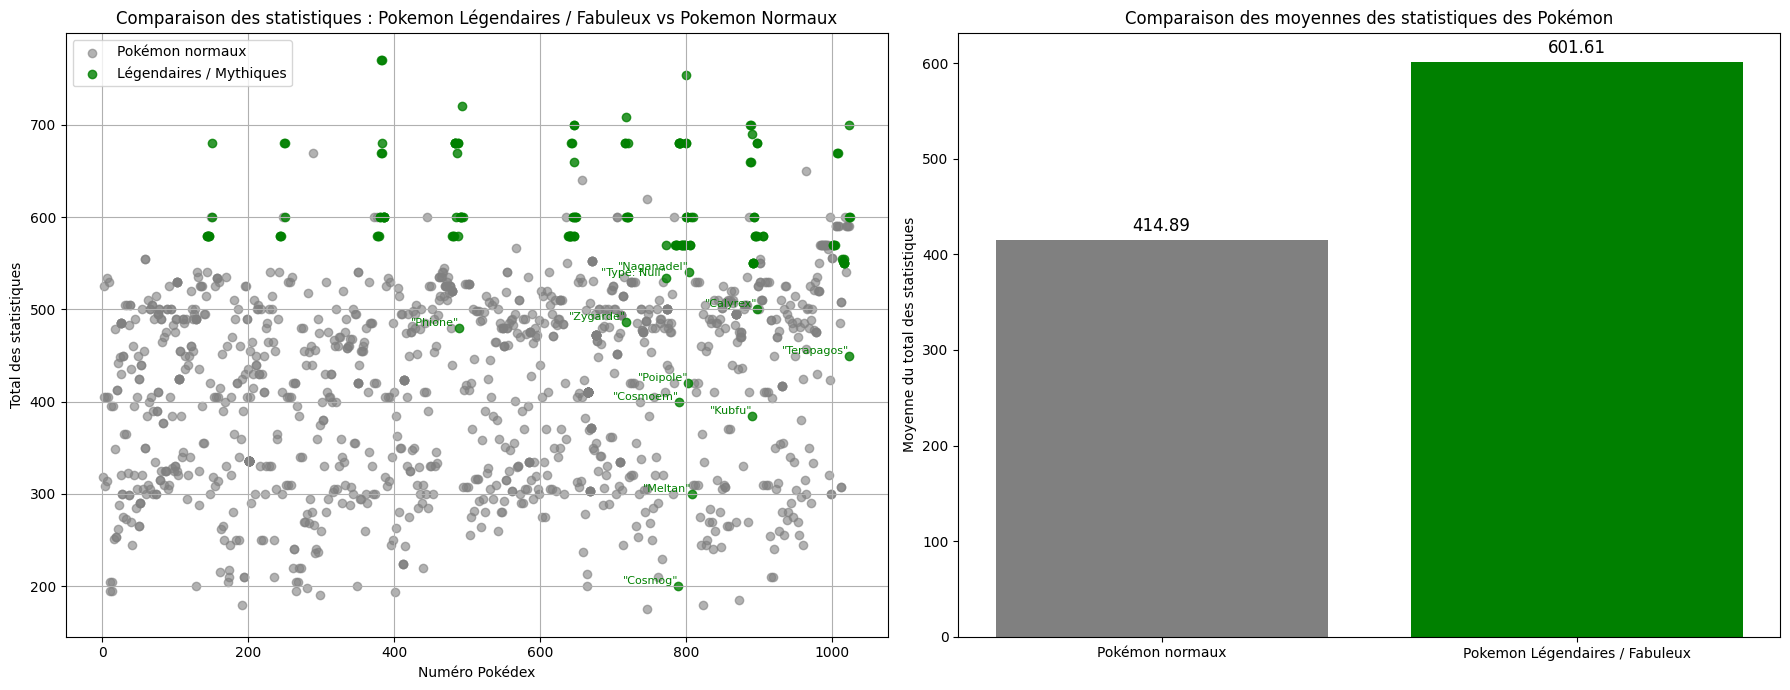

In [ ]:
# Charger les données
file_path = 'Dataset/PokemonDatabase.csv'
df = pd.read_csv(file_path)

# Nettoyage
df = df[~df["Alternate Form Name"].astype(str).str.contains("Mega|Gigantamax|Eternamax", na=False)]
df.loc[df["Pokemon Name"].str.startswith('"Unown'), "Pokemon Name"] = '"Unown"'

# Nettoyage des valeurs de "Legendary Type"
df["Legendary Type"] = df["Legendary Type"].astype(str).str.replace('"', '').str.strip()

# Définition des Pokemon Légendaires / Fabuleux et Pokemon normaux
legendary_types = ["Legendary", "Mythical", "Sub-Legendary"]
df_legendary_pokemon = df["Legendary Type"].isin(legendary_types)

# Création du scatter plot
fig, ax = plt.subplots(1, 2, figsize=(18, 7))

# Affichage des Pokémon normaux (gris)
ax[0].scatter(df.loc[~df_legendary_pokemon, "Pokedex Number"],
              df.loc[~df_legendary_pokemon, "Base Stat Total"],
              color="gray", label="Pokémon normaux", alpha=0.6)

# Affichage des Pokémon Pokemon Légendaires / Fabuleux (verts)
ax[0].scatter(df.loc[df_legendary_pokemon, "Pokedex Number"],
              df.loc[df_legendary_pokemon, "Base Stat Total"],
              color="green", label="Légendaires / Mythiques", alpha=0.8)

# Affichage des noms des Pokémon dont le "Base Stat Total" est inférieur à 550
for _, row in df[(df["Base Stat Total"] < 550) & df_legendary_pokemon].iterrows():
    ax[0].text(row["Pokedex Number"], row["Base Stat Total"], row["Pokemon Name"],
               fontsize=8, ha='right', va='bottom', color='green')

# Titres et légendes pour le scatter plot
ax[0].set_xlabel("Numéro Pokédex")
ax[0].set_ylabel("Total des statistiques")
ax[0].set_title("Comparaison des statistiques : Pokemon Légendaires / Fabuleux vs Pokemon Normaux")
ax[0].legend()
ax[0].grid(True)

# Calcul des moyennes des stats des Pokémon Pokemon Légendaires / Fabuleux et normaux
mean_legendary = df[df_legendary_pokemon]["Base Stat Total"].mean()
mean_normal = df[~df_legendary_pokemon]["Base Stat Total"].mean()

# Création de l'histogramme des moyennes
bars = ax[1].bar(["Pokémon normaux", "Pokemon Légendaires / Fabuleux"], [mean_normal, mean_legendary], color=['gray', 'green'])

# Affichage des valeurs sur l'histogramme
for bar in bars:
    yval = bar.get_height()
    ax[1].text(bar.get_x() + bar.get_width() / 2, yval + 5, round(yval, 2), ha='center', va='bottom', fontsize=12)

# Ajout des titres et légendes pour l'histogramme
ax[1].set_ylabel("Moyenne du total des statistiques")
ax[1].set_title("Comparaison des moyennes des statistiques des Pokémon")

# Affichage du graphique
plt.tight_layout()
plt.show()


### Intérêt du graphique et Analyse ###

Ces graphiques ont pour but de montrer s'il existe une différence de statistique totale notable entre les pokemon légendaires/fabuleux et le reste des pokemon.

Grâce au nuage de point (graph gauche) il est facile d'observer une segmentation nette à environ 550 pour le total des statistiques, où on remarque que les légendaires sont majoritairement au dessus de ce seuil et le reste des pokemon majoritairement en dessous.
Seules quelques exceptions de pokemon non-légendaires/fabuleux dépassent un total de statistiques de 550, ils sont regroupés dans la catégorie des types dragons qui sont les seuls à avoir une réputation d'avoir plus de statistiques que la moyenne globale. Concernant les pokemon légendaires/fabuleux les exceptions sont des pokemon partiellement complet (Zygarde 5%) ou des formes qui servent à l'histoire du jeux et donc qui ne sont jouables que lors de leur dernière forme (Cosmog, Cosmoen, Phione, Meltan, Kubfu, terapagos, Vémini), sur le graphique ils ont été mis en lumière pour pouvoir comprendre leur cas unique.   
Ce graphique permet donc de confirmer que les Pokémon légendaires sont globalement bien plus puissants et doivent donc être étudiés à part des Pokemon non-légendaires dans l’analyse.

Le BarPlot (graph droite) permet de visuellement bien voir la supériorité global des pokemon légendaires/fabuleux sur le reste des pokemon grâce à la moyenne des statistique de chaque catégorie. Avec 185 points de statistiques en plus pour les pokemon légendaires/fabuleux soit un équivalent de 145% des stats des pokemon non légendaires/fabuleux.

Nombre de Pokémon par couleur :
Color
blue    558
red     404
grey    188
Name: count, dtype: int64


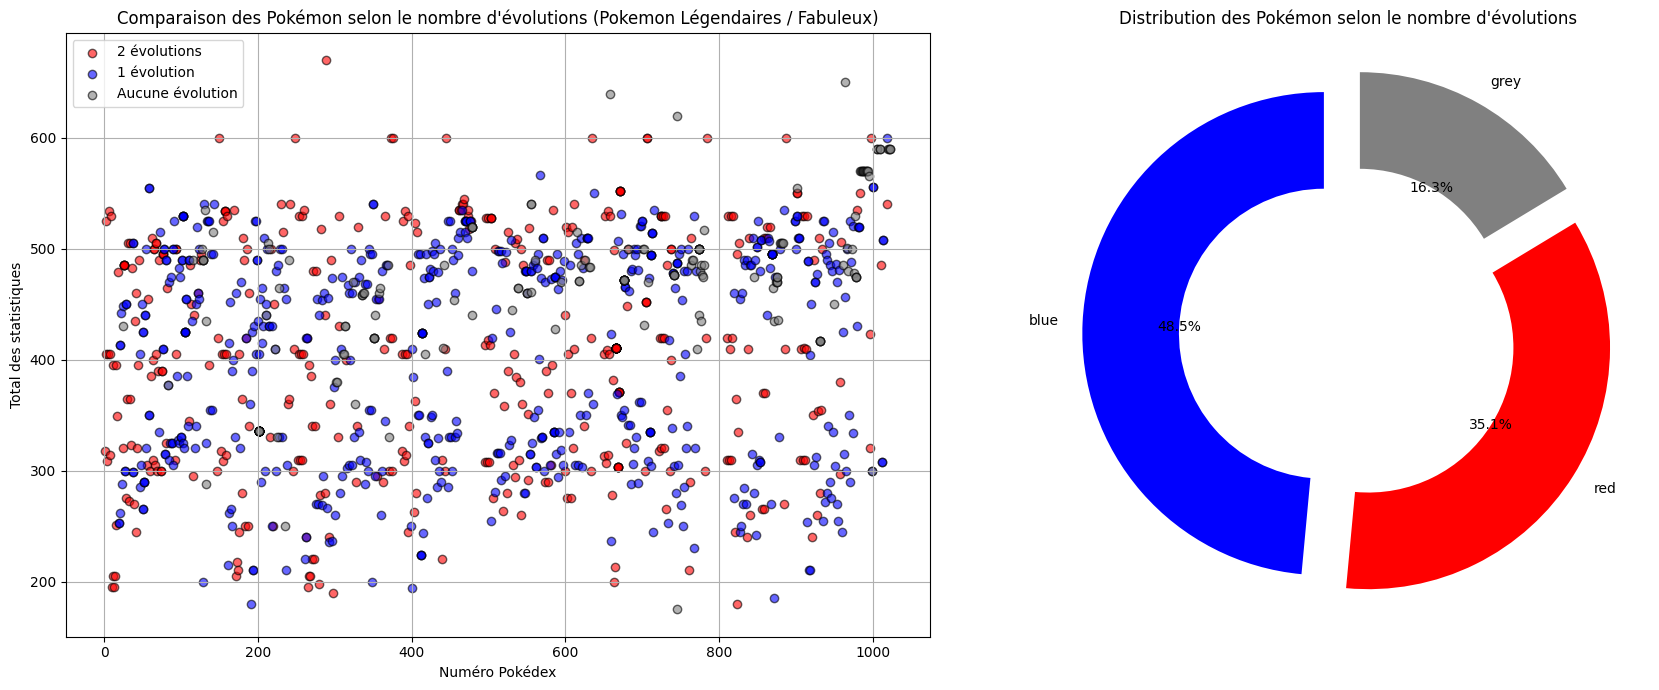

In [38]:
# Exclure les Pokémon Pokemon Légendaires / Fabuleux
df_base_pokemon = df[~df_legendary_pokemon].copy()  # Création d'une copie


# Créer un dictionnaire pour mapper les IDs d'évolution
pokemon_id_dict = dict(zip(df_base_pokemon["Pokemon Id"], df_base_pokemon["Pokemon Name"]))

# Fonction pour trouver la chaîne d'évolution à partir d'un Pokémon donné
def get_evolution_chain(pokemon_id, df):
    chain = [pokemon_id]
    current_pokemon = df_base_pokemon[df_base_pokemon["Pokemon Id"] == pokemon_id]

    # Remonter la chaîne d'évolution en suivant les pré-évolutions
    while not current_pokemon["Pre-Evolution Pokemon Id"].isnull().values[0]:
        pre_evolution_id = current_pokemon["Pre-Evolution Pokemon Id"].values[0]
        chain.append(pre_evolution_id)
        current_pokemon = df_base_pokemon[df_base_pokemon["Pokemon Id"] == pre_evolution_id]

    return chain

# Créer une colonne pour stocker la couleur des points
df_base_pokemon['Color'] = 'grey'  # Initialisation avec 'grey' (aucune évolution)

# Mettre à jour la couleur pour les Pokémon selon la chaîne d'évolutions
for _, row in df_base_pokemon.iterrows():
    chain = get_evolution_chain(row["Pokemon Id"], df_base_pokemon)
    # Si la chaîne contient 3 Pokémon (2 évolutions), colorier en rouge
    if len(chain) == 3:
        df_base_pokemon.loc[df_base_pokemon["Pokemon Id"].isin(chain), 'Color'] = 'red'
    # Si la chaîne contient 2 Pokémon (1 évolution), colorier en bleu
    elif len(chain) == 2:
        df_base_pokemon.loc[df_base_pokemon["Pokemon Id"].isin(chain), 'Color'] = 'blue'

# Affichage du nombre de chaque couleur
color_counts = df_base_pokemon['Color'].value_counts()
print("Nombre de Pokémon par couleur :")
print(color_counts)

# Création du graphique
fig, ax = plt.subplots(1, 2, figsize=(18, 7))

# Première partie : Nuage de points
# Affichage des Pokémon avec la couleur de la chaîne d'évolution
scatter_red = ax[0].scatter(df_base_pokemon.loc[df_base_pokemon['Color'] == 'red', "Pokedex Number"],
                            df_base_pokemon.loc[df_base_pokemon['Color'] == 'red', "Base Stat Total"],
                            color='red', label='2 évolutions', alpha=0.6, edgecolors='black')

scatter_blue = ax[0].scatter(df_base_pokemon.loc[df_base_pokemon['Color'] == 'blue', "Pokedex Number"],
                             df_base_pokemon.loc[df_base_pokemon['Color'] == 'blue', "Base Stat Total"],
                             color='blue', label='1 évolution', alpha=0.6, edgecolors='black')

scatter_grey = ax[0].scatter(df_base_pokemon.loc[df_base_pokemon['Color'] == 'grey', "Pokedex Number"],
                              df_base_pokemon.loc[df_base_pokemon['Color'] == 'grey', "Base Stat Total"],
                              color='grey', label='Aucune évolution', alpha=0.6, edgecolors='black')

# Titres et légendes
ax[0].set_xlabel("Numéro Pokédex")
ax[0].set_ylabel("Total des statistiques")
ax[0].set_title("Comparaison des Pokémon selon le nombre d'évolutions (Pokemon Légendaires / Fabuleux)")

# Affichage de la légende
ax[0].legend()
ax[0].grid(True)

# Deuxième partie : Donut Chart
# Création du donut chart
labels = color_counts.index
sizes = color_counts.values
explode = (0.1, 0.1, 0.1)  # Séparation des tranches pour l'effet visuel

ax[1].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['blue', 'red', 'grey'], explode=explode, wedgeprops={'width': 0.4})
ax[1].set_title("Distribution des Pokémon selon le nombre d'évolutions")

# Affichage du graphique
plt.tight_layout()
plt.show()


### Intérêt du graphique et Analyse ###

Ce premier double graphique montre la répartition des Pokémon non légendaires en fonction de leur nombre d’évolutions.

- **Nuage de points (gauche)** : On visualise chaque Pokémon selon son numéro de Pokédex et son total de statistiques de base. Les couleurs correspondent au nombre d’évolutions :
  - 🔴 Rouge : Pokémon avec deux évolutions
  - 🔵 Bleu : Pokémon avec une seule évolution
  - ⚫ Gris : Pokémon sans évolution

On observe que plus un Pokémon possède d’évolutions, plus il tend à avoir un total de statistiques élevé. Ceux avec deux évolutions atteignent globalement de meilleurs scores. Là où les Pokemon n'ayant qu'une seule évolution sont plutôt sur un total des statistiques à 500 et 300, et les Pokemon sans évolution sont plus bas en termes de statistiques, sauf pour quelques exceptions.

- **Donut Chart (droite)** : Ce diagramme circulaire donne un aperçu de la distribution des Pokémon selon leur nombre d’évolutions. On voit une majorité de Pokémon ayant une évolution, suivis de ceux avec deux, et enfin, une minorité qui ceux sans aucune évolution.


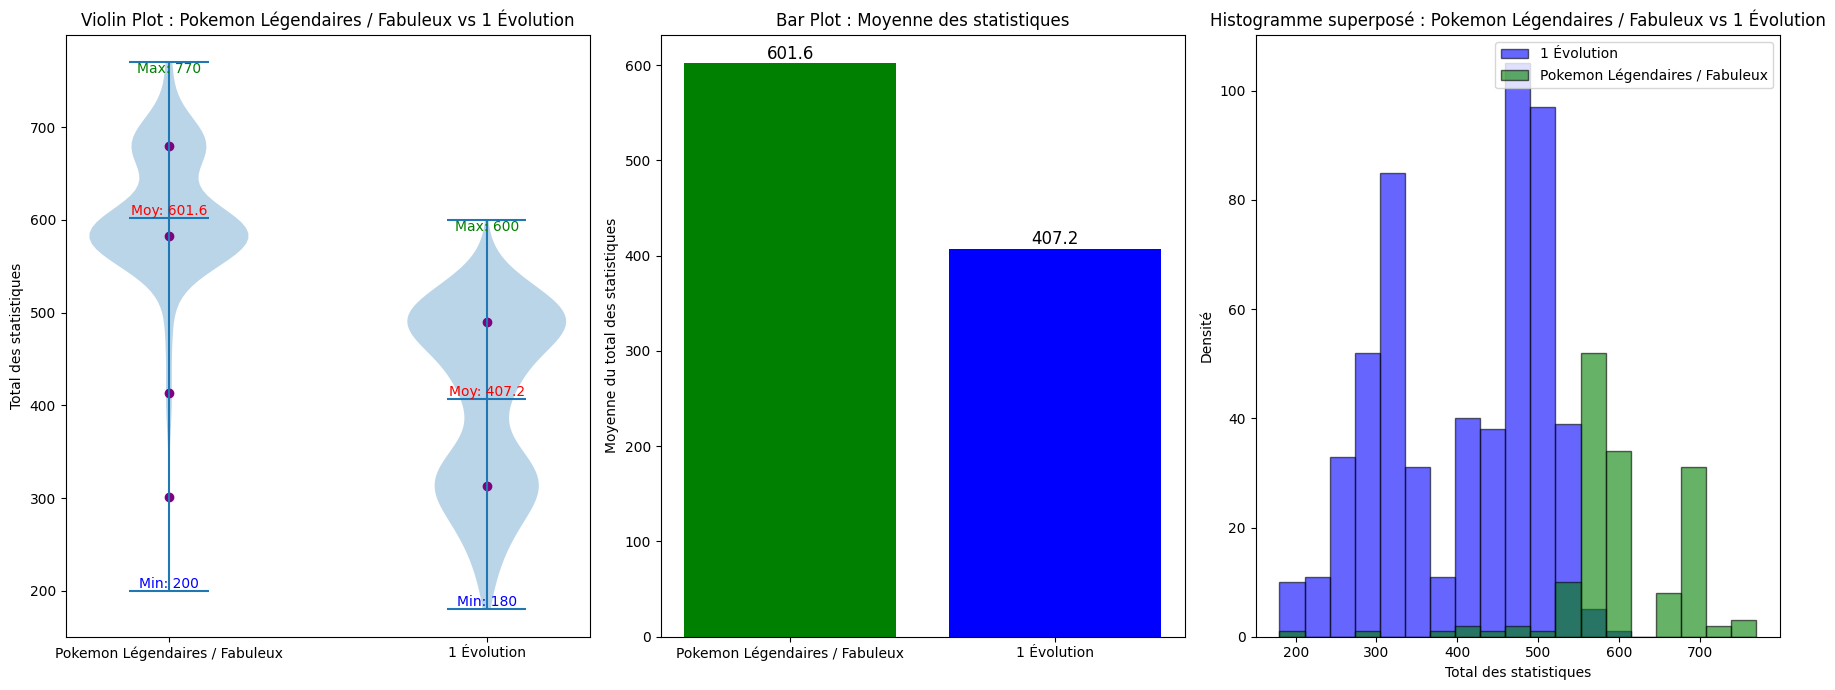

In [ ]:
# Filtrer les Pokémon Pokemon Légendaires / Fabuleux et ceux ayant 1 évolution
df_single_evolution = df_base_pokemon[df_base_pokemon['Color'] == 'blue']  # Pokémon avec 1 évolution
df_legendary_pokemon = df[df_legendary_pokemon]  # Fait gaffe à ce que df_legendary_pokemon soit déjà bien filtré

# Extraire les valeurs pour les statistiques de base
stats_single_evolution = df_single_evolution['Base Stat Total'].values
stats_legendary = df_legendary_pokemon['Base Stat Total'].values

# Calcul des statistiques pour affichage
mean_stats = [np.mean(stats_legendary), np.mean(stats_single_evolution)]
min_stats = [np.min(stats_legendary), np.min(stats_single_evolution)]
max_stats = [np.max(stats_legendary), np.max(stats_single_evolution)]

# Fonction pour trouver les pics (modes)
def find_peaks(data):
    kde = gaussian_kde(data)  # Densité de probabilité
    x_vals = np.linspace(min(data), max(data), 1000)
    y_vals = kde(x_vals)

    peak_indices = np.where((y_vals[1:-1] > y_vals[:-2]) & (y_vals[1:-1] > y_vals[2:]))[0] + 1
    peaks = x_vals[peak_indices]

    return peaks

peaks_legendary = find_peaks(stats_legendary)
peaks_single_evolution = find_peaks(stats_single_evolution)

# Création du graphique
fig, ax = plt.subplots(1, 3, figsize=(18, 7))

# 1. Violin Plot avec stats et pics
parts = ax[0].violinplot([stats_legendary, stats_single_evolution], showmeans=True, showextrema=True)

# Ajouter les valeurs min, max et moyennes
for i, (mean, min_val, max_val, peaks) in enumerate(zip(mean_stats, min_stats, max_stats, [peaks_legendary, peaks_single_evolution]), start=1):
    ax[0].text(i, mean, f'Moy: {mean:.1f}', ha='center', va='bottom', fontsize=10, color='red')
    ax[0].text(i, min_val, f'Min: {min_val}', ha='center', va='bottom', fontsize=10, color='blue')
    ax[0].text(i, max_val, f'Max: {max_val}', ha='center', va='top', fontsize=10, color='green')

    # Ajouter les pics (modes)
    for peak in peaks:
        ax[0].scatter(i, peak, color='purple', marker='o', label='Pic' if i == 1 else "")

ax[0].set_xticks([1, 2])
ax[0].set_xticklabels(["Pokemon Légendaires / Fabuleux", "1 Évolution"])
ax[0].set_title("Violin Plot : Pokemon Légendaires / Fabuleux vs 1 Évolution")
ax[0].set_ylabel("Total des statistiques")

# 2. Bar Plot avec affichage des valeurs précises
bars = ax[1].bar(["Pokemon Légendaires / Fabuleux", "1 Évolution"], mean_stats, color=['green', 'blue'])

# Ajouter les valeurs des moyennes sur les barres
for bar, value in zip(bars, mean_stats):
    ax[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, f'{value:.1f}', ha='center', fontsize=12)

ax[1].set_title("Bar Plot : Moyenne des statistiques")
ax[1].set_ylabel("Moyenne du total des statistiques")

# 3. Histogramme superposé
bins = np.linspace(min(min(stats_single_evolution), min(stats_legendary)),
                   max(max(stats_single_evolution), max(stats_legendary)), 20)

ax[2].hist(stats_single_evolution, bins=bins, color='blue', alpha=0.6, label="1 Évolution", edgecolor='black')
ax[2].hist(stats_legendary, bins=bins, color='green', alpha=0.6, label="Pokemon Légendaires / Fabuleux", edgecolor='black')

ax[2].set_title("Histogramme superposé : Pokemon Légendaires / Fabuleux vs 1 Évolution")
ax[2].set_xlabel("Total des statistiques")
ax[2].set_ylabel("Densité")
ax[2].legend()

# Affichage du graphique
plt.tight_layout()
plt.show()


### Intérêt du graphique et Analyse ###

Ces trois graphiques permettent de comparer les statistiques entre les Pokémon légendaires/fabuleux et les Pokémon non légendaires ayant une seule évolution.

- **Violin Plot (gauche)** : Ce graphique illustre la distribution des totaux de statistiques. Les légendaires ont une concentration plus haute, avec une moyenne significativement supérieure. Les pics (modes) sont également visibles, signalant des zones où les totaux de stats sont fréquents : 600 et plus pour les légendaires et 500 et moins pour les Pokemon à une évolution.
- **Bar Plot (centre)** : Ce graphique compare directement les moyennes de statistiques. Les Pokémon légendaires dépassent clairement ceux qui n'ont qu'une seule évolution avec une différence de 194 points.
- **Histogramme (droite)** : Ce graphique montre les distributions. Encore une fois, les Pokemon légendaire sont clairement décalés vers des valeurs plus élevées (550 et plus) par rapport aux Pokemon à une évolution (550 et moins).


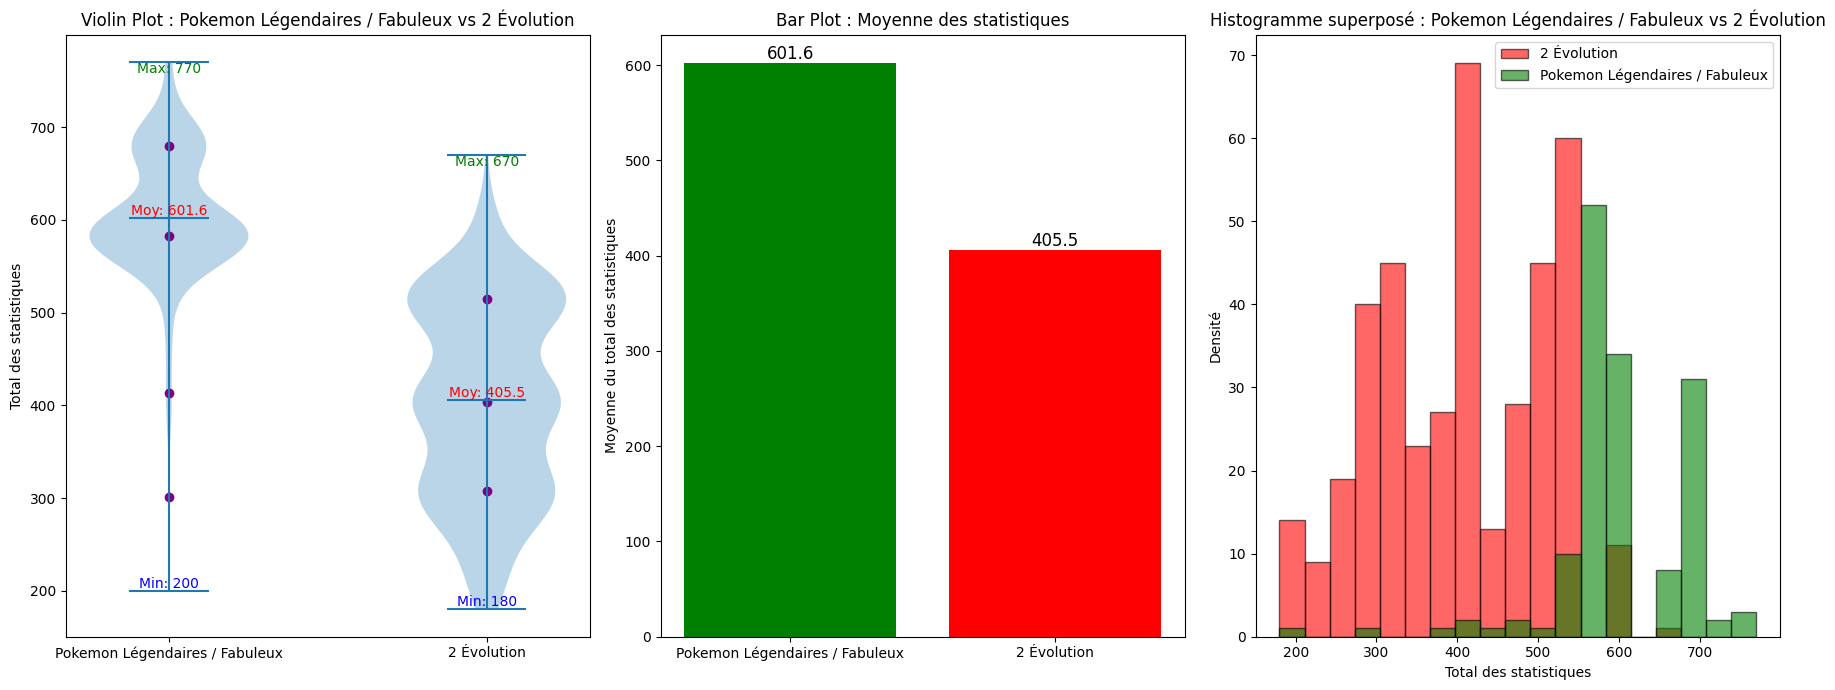

In [33]:

# Filtrer les Pokémon Pokemon Légendaires / Fabuleux et ceux ayant 1 évolution
df_two_evolution = df_base_pokemon[df_base_pokemon['Color'] == 'red']  # Pokémon avec 1 évolution

# Extraire les valeurs pour les statistiques de base
stats_two_evolution = df_two_evolution['Base Stat Total'].values
stats_legendary = df_legendary_pokemon['Base Stat Total'].values

# Calcul des statistiques pour affichage
mean_stats = [np.mean(stats_legendary), np.mean(stats_two_evolution)]
min_stats = [np.min(stats_legendary), np.min(stats_two_evolution)]
max_stats = [np.max(stats_legendary), np.max(stats_two_evolution)]


# Fonction pour trouver les pics (modes)
def find_peaks(data):
    kde = gaussian_kde(data)  # Densité de probabilité
    x_vals = np.linspace(min(data), max(data), 1000)
    y_vals = kde(x_vals)

    peak_indices = np.where((y_vals[1:-1] > y_vals[:-2]) & (y_vals[1:-1] > y_vals[2:]))[0] + 1
    peaks = x_vals[peak_indices]

    return peaks


peaks_legendary = find_peaks(stats_legendary)
peaks_two_evolution = find_peaks(stats_two_evolution)

# Création du graphique
fig, ax = plt.subplots(1, 3, figsize=(18, 7))

# 1. Violin Plot avec stats et pics
parts = ax[0].violinplot([stats_legendary, stats_two_evolution], showmeans=True, showextrema=True)

# Ajouter les valeurs min, max et moyennes
for i, (mean, min_val, max_val, peaks) in enumerate(
        zip(mean_stats, min_stats, max_stats, [peaks_legendary, peaks_two_evolution]), start=1):
    ax[0].text(i, mean, f'Moy: {mean:.1f}', ha='center', va='bottom', fontsize=10, color='red')
    ax[0].text(i, min_val, f'Min: {min_val}', ha='center', va='bottom', fontsize=10, color='blue')
    ax[0].text(i, max_val, f'Max: {max_val}', ha='center', va='top', fontsize=10, color='green')

    # Ajouter les pics (modes)
    for peak in peaks:
        ax[0].scatter(i, peak, color='purple', marker='o', label='Pic' if i == 1 else "")

ax[0].set_xticks([1, 2])
ax[0].set_xticklabels(["Pokemon Légendaires / Fabuleux", "2 Évolution"])
ax[0].set_title("Violin Plot : Pokemon Légendaires / Fabuleux vs 2 Évolution")
ax[0].set_ylabel("Total des statistiques")

# 2. Bar Plot avec affichage des valeurs précises
bars = ax[1].bar(["Pokemon Légendaires / Fabuleux", "2 Évolution"], mean_stats, color=['green', 'red'])

# Ajouter les valeurs des moyennes sur les barres
for bar, value in zip(bars, mean_stats):
    ax[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, f'{value:.1f}', ha='center', fontsize=12)

ax[1].set_title("Bar Plot : Moyenne des statistiques")
ax[1].set_ylabel("Moyenne du total des statistiques")

# 3. Histogramme superposé
bins = np.linspace(min(min(stats_two_evolution), min(stats_legendary)),
                   max(max(stats_two_evolution), max(stats_legendary)), 20)

ax[2].hist(stats_two_evolution, bins=bins, color='red', alpha=0.6, label="2 Évolution", edgecolor='black')
ax[2].hist(stats_legendary, bins=bins, color='green', alpha=0.6, label="Pokemon Légendaires / Fabuleux", edgecolor='black')

ax[2].set_title("Histogramme superposé : Pokemon Légendaires / Fabuleux vs 2 Évolution")
ax[2].set_xlabel("Total des statistiques")
ax[2].set_ylabel("Densité")
ax[2].legend()

# Affichage du graphique
plt.tight_layout()
plt.show()

### Intérêt du graphique et Analyse ###

Même logique que précédemment, mais ici on compare les Pokémon légendaires/fabuleux aux Pokémon avec **deux évolutions**.

- **Violin Plot** : Bien que les Pokémon avec deux évolutions aient une bonne répartition, leur moyenne est presque la même que les Pokemon à une évolution, ils restent donc bien en dessous des légendaires.
- **Bar Plot** : La différence de moyenne reste identique à celle des Pokemon à une seule évolution, avec presque la même différence de stat énorme de 196.
- **Histogramme** : On remarque que certains Pokémon avec deux évolutions atteignent presque les niveaux des légendaires, mais ils sont rares et le résultat reste le même que celui des Pokemon à une seule évolution : Pokemon légendaire à 550 et plus et Pokemon à 2 évolutions à 550 et moins points de statistiques.


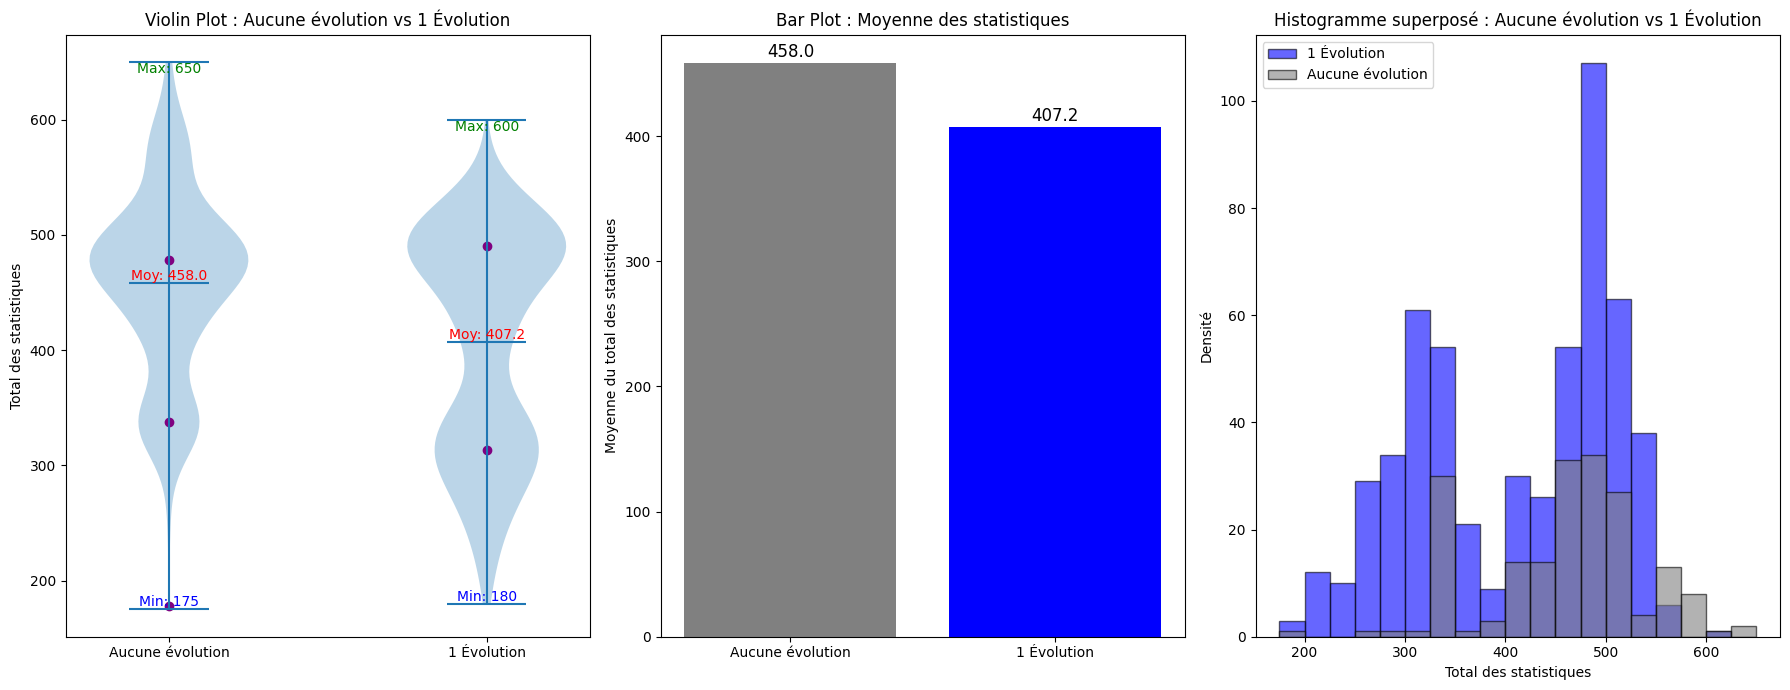

In [ ]:
# Filtrer les Pokémon avec Aucune évolution et ceux ayant 1 évolution
df_none_evolution = df_base_pokemon[df_base_pokemon['Color'] == 'grey']

# Extraire les valeurs pour les statistiques de base
stats_none_evolution = df_none_evolution['Base Stat Total'].values

# Calcul des statistiques pour affichage
mean_stats = [np.mean(stats_none_evolution), np.mean(stats_single_evolution)]
min_stats = [np.min(stats_none_evolution), np.min(stats_single_evolution)]
max_stats = [np.max(stats_none_evolution), np.max(stats_single_evolution)]

# Fonction pour trouver les pics (modes)
def find_peaks(data):
    kde = gaussian_kde(data)  # Densité de probabilité
    x_vals = np.linspace(min(data), max(data), 1000)
    y_vals = kde(x_vals)

    peak_indices = np.where((y_vals[1:-1] > y_vals[:-2]) & (y_vals[1:-1] > y_vals[2:]))[0] + 1
    peaks = x_vals[peak_indices]

    return peaks

peaks_none_evolution = find_peaks(stats_none_evolution)

# Création du graphique
fig, ax = plt.subplots(1, 3, figsize=(18, 7))

# 1. Violin Plot avec stats et pics
parts = ax[0].violinplot([stats_none_evolution, stats_single_evolution], showmeans=True, showextrema=True)

# Ajouter les valeurs min, max et moyennes
for i, (mean, min_val, max_val, peaks) in enumerate(zip(mean_stats, min_stats, max_stats, [peaks_none_evolution, peaks_single_evolution]), start=1):
    ax[0].text(i, mean, f'Moy: {mean:.1f}', ha='center', va='bottom', fontsize=10, color='red')
    ax[0].text(i, min_val, f'Min: {min_val}', ha='center', va='bottom', fontsize=10, color='blue')
    ax[0].text(i, max_val, f'Max: {max_val}', ha='center', va='top', fontsize=10, color='green')

    # Ajouter les pics (modes)
    for peak in peaks:
        ax[0].scatter(i, peak, color='purple', marker='o', label='Pic' if i == 1 else "")

ax[0].set_xticks([1, 2])
ax[0].set_xticklabels(["Aucune évolution", "1 Évolution"])
ax[0].set_title("Violin Plot : Aucune évolution vs 1 Évolution")
ax[0].set_ylabel("Total des statistiques")

# 2. Bar Plot avec affichage des valeurs précises
bars = ax[1].bar(["Aucune évolution", "1 Évolution"], mean_stats, color=['grey', 'blue'])

# Ajouter les valeurs des moyenes sur les barres
for bar, value in zip(bars, mean_stats):
    ax[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, f'{value:.1f}', ha='center', fontsize=12)

ax[1].set_title("Bar Plot : Moyenne des statistiques")
ax[1].set_ylabel("Moyenne du total des statistiques")

# 3. Histogramme superposé
bins = np.linspace(min(min(stats_single_evolution), min(stats_none_evolution)),
                   max(max(stats_single_evolution), max(stats_none_evolution)), 20)

ax[2].hist(stats_single_evolution, bins=bins, color='blue', alpha=0.6, label="1 Évolution", edgecolor='black')
ax[2].hist(stats_none_evolution, bins=bins, color='grey', alpha=0.6, label="Aucune évolution", edgecolor='black')

ax[2].set_title("Histogramme superposé : Aucune évolution vs 1 Évolution")
ax[2].set_xlabel("Total des statistiques")
ax[2].set_ylabel("Densité")
ax[2].legend()

# Affichage du graphique
plt.tight_layout()
plt.show()


### Intérêt du graphique et Analyse ###

Ces graphiques comparent uniquement les Pokémon non légendaires, entre ceux **sans évolution** et ceux **ayant une seule**.

- **Violin Plot** : On voit une légère supériorité des Pokémon sans évolution. Les moyennes et les extrêmes indiquent que ceux qui évoluent ont tendance à être plus faibles. 
- **Bar Plot** : Les moyennes des statistiques montrent que les Pokemon sans évolution dépassent les Pokemon avec une seule évolution, avec une solide différence de 51 points.
- **Histogramme** : Les Pokémon avec 1 évolution ont en moyenne de meilleures statistiques de base que ceux sans aucune évolution. Ils sont non seulement plus nombreux dans les tranches élevées, mais ont aussi un pic significatif autour de 500 points. Quelques Pokemon à une évolution dépassent 500 points mais ils sont majoritairement entre 300 et 450 points.


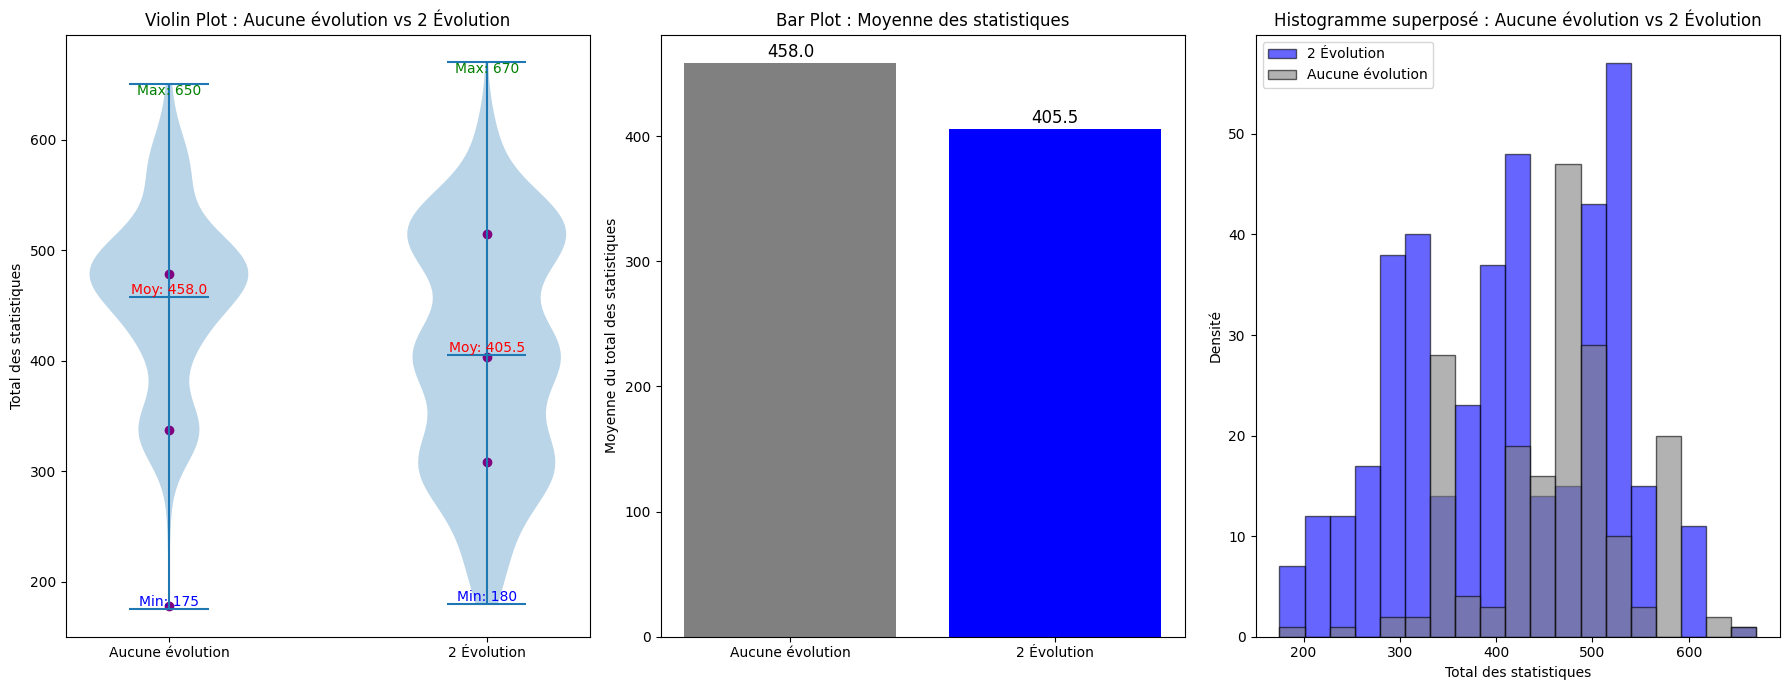

In [ ]:

# Calcul des statistiques pour affichage
mean_stats = [np.mean(stats_none_evolution), np.mean(stats_two_evolution)]
min_stats = [np.min(stats_none_evolution), np.min(stats_two_evolution)]
max_stats = [np.max(stats_none_evolution), np.max(stats_two_evolution)]

# Fonction pour trouver les pics (modes)
def find_peaks(data):
    kde = gaussian_kde(data)  # Densité de probabilité
    x_vals = np.linspace(min(data), max(data), 1000)
    y_vals = kde(x_vals)

    peak_indices = np.where((y_vals[1:-1] > y_vals[:-2]) & (y_vals[1:-1] > y_vals[2:]))[0] + 1
    peaks = x_vals[peak_indices]

    return peaks

peaks_none_evolution = find_peaks(stats_none_evolution)

# Création du graphique
fig, ax = plt.subplots(1, 3, figsize=(18, 7))

# 1. Violin Plot avec stats et pics
parts = ax[0].violinplot([stats_none_evolution, stats_two_evolution], showmeans=True, showextrema=True)

# Ajouter les valeurs min, max et moyennes
for i, (mean, min_val, max_val, peaks) in enumerate(zip(mean_stats, min_stats, max_stats, [peaks_none_evolution, peaks_two_evolution]), start=1):
    ax[0].text(i, mean, f'Moy: {mean:.1f}', ha='center', va='bottom', fontsize=10, color='red')
    ax[0].text(i, min_val, f'Min: {min_val}', ha='center', va='bottom', fontsize=10, color='blue')
    ax[0].text(i, max_val, f'Max: {max_val}', ha='center', va='top', fontsize=10, color='green')

    # Ajouter les pics (modes)
    for peak in peaks:
        ax[0].scatter(i, peak, color='purple', marker='o', label='Pic' if i == 1 else "")

ax[0].set_xticks([1, 2])
ax[0].set_xticklabels(["Aucune évolution", "2 Évolution"])
ax[0].set_title("Violin Plot : Aucune évolution vs 2 Évolution")
ax[0].set_ylabel("Total des statistiques")

# 2. Bar Plot avec affichage des valeurs précises
bars = ax[1].bar(["Aucune évolution", "2 Évolution"], mean_stats, color=['grey', 'blue'])

# Ajouter les valeurs des moyenes sur les barres
for bar, value in zip(bars, mean_stats):
    ax[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, f'{value:.1f}', ha='center', fontsize=12)

ax[1].set_title("Bar Plot : Moyenne des statistiques")
ax[1].set_ylabel("Moyenne du total des statistiques")

# 3. Histogramme superposé
bins = np.linspace(min(min(stats_two_evolution), min(stats_none_evolution)),
                   max(max(stats_two_evolution), max(stats_none_evolution)), 20)

ax[2].hist(stats_two_evolution, bins=bins, color='blue', alpha=0.6, label="2 Évolution", edgecolor='black')
ax[2].hist(stats_none_evolution, bins=bins, color='grey', alpha=0.6, label="Aucune évolution", edgecolor='black')

ax[2].set_title("Histogramme superposé : Aucune évolution vs 2 Évolution")
ax[2].set_xlabel("Total des statistiques")
ax[2].set_ylabel("Densité")
ax[2].legend()

# Affichage du graphique
plt.tight_layout()
plt.show()


### Intérêt du graphique et Analyse ###

Ici on compare les extrêmes : Pokémon sans évolution et ceux avec deux évolutions.

- **Violin Plot** : La plus grande réparition des Pokemon à deux évolution en termes de total de statistiques crée une moyenne plus basse que celle des Pokemon sans évolution, malgré un pic plus haut que celui des Pokemon sans évolution (458 points) à 510 points.
- **Bar Plot** : Les moyennes des statistiques montrent que les Pokemon sans évolution dépassent les Pokemon avec deux évolution, avec une solide différence de 53 points.
- **Histogramme** : On observe deux distributions bien distinctes, les Pokemon à deux évolution sont très répartis, entre 150 et 600, là où les Pokemon sans évolution sont groupés à 350, 480 et 580 points. Cela montre que malgré la moyenne des statistiques des Pokemon sans évolution plus haute, certains Pokemon à deux évolution sont supérieur. 

# Conclusion de l'analyse

À travers l’analyse des statistiques des Pokémon selon leur statut (légendaire ou non) et leur nombre d’évolutions, nous pouvons tirer plusieurs constats :

- Les Pokémon légendaires/fabuleux possèdent des statistiques de base nettement supérieures aux Pokémon normaux. Leur moyenne est à 602 points, contre 415 pour les autres. Ils doivent donc être étudiés séparément, afin de ne pas fausser les comparaisons.

- Comme attendu pour les Pokemon légendaires, les résultats obtenus sont qu'ils ont beaucoup plus de statistiques que les Pokemon à évolution, avec quand même quelques petites exceptions.

- Concernant les Pokémon non légendaires, les résultats obtenus vont à l’encontre des attentes classiques :

  Les Pokémon sans évolution ont, en moyenne, des statistiques nettement plus élevées que ceux qui possèdent une ou deux évolutions.

❓ Cette observation peut s'expliquer par le fait que ces Pokémon sans évolution sont souvent conçus pour être directement viables en l'état (ex : Pokémon obtenus tardivement, ou formes uniques).
À l’inverse, les Pokémon évolutifs ont une progression plus étalée ou unique.



**Réponse à la problématique** :  
Non, il n'existe pas une différence notable de statistiques selon le nombre d’évolutions. L’évolution ne semble pas déterminant en termes de statistiques dans la puissance globale d’un Pokémon, voir l'inverse. Visible par le fait que les Pokemon sans évolution possédent plus de statistiques que les Pokemon évoluant.

# De quoi approfondir le sujet 


L'analyse a montré que les statistiques jouent en la défaveur des Pokemon à évolution. Voici une théorie formulée par nos soins pour en trouver la raison : 

Définition talents dans Pokemon : les talents sont des capacités innés aux Pokemon qui peuvent s'améliorer grâce aux évolutions.     
Définition moovesets dans Pokemon : les moovesets (combinaison d'attaques limités à 4) puissants sont accessibles aux Pokemon dans leur forme finale (dernière évolution ou aucune évolution).    
Définition synergies dans Pokemon : les synergies sont des combinaison avantageuses de moovesets puissants et de talents puissants qui marchent souvent sous des conditions précises.   
Les moovesets des Pokemon évolués pourraient leur permettre de créer un environnement où leur talent révèle tout son potentiel.

Les Pokemon à évolution pourraient donc gagner des synergies à la place des statistiques afin de compenser la différence de statistiques.

Afin de tester cette théorie il faudrait avoir accès à des données qui donne une valeur compétitive aux synergies de tout les Pokemon.